In [1]:
!nvidia-smi

Thu Feb 15 13:13:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P8              20W / 215W |    379MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/ravdess/preprocessed16k/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}ravdess.audio.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}ravdess.audio.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}ravdess.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}ravdess.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}ravdess.labels.test.npy', allow_pickle=True)

In [9]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

46980
84351


59211.48957298908

In [10]:
l = [len(i) for i in x_test]
print(min(l))
print(max(l))
sum(l) / len(l)

47514
77411


59135.474048442906

In [11]:
def process(x, max_len=46600):
    y = []
    for i in x:
        i = i.squeeze()
        if len(i) > max_len:
            offset = max(0, (len(i) - max_len) // 2)
            yy = i[offset:offset+max_len]
        else:
            yy = i
        y.append(yy)
    return np.stack(y, axis=-1).T


In [12]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(process(x_train))[:, None ,:]
    y_train = torch.tensor(y_train - 1, dtype=torch.int64)
    x_test = torch.tensor(process(x_test))[:, None, :]
    y_test = torch.tensor(y_test - 1, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [13]:
batch_size = 16
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [17]:
from IConNet.nn.model import M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
model_config_path = 'config/model/m13_ravdess.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13_ravdess', 'description': 'FirConv M13 for ravdess', 'fe': {'n_block': 2, 'n_channel': [128, 64], 'kernel_size': [511, 127], 'stride': [4, 2], 'groups': [1, 1], 'window_k': [2, 5], 'residual_connection_type': 'stack', 'pooling': 'mean', 'conv_type': 'firwin', 'conv_mode': 'conv', 'n_fft': False, 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [320, 320], 'norm_type': 'LayerNorm'}}

In [18]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (pad): PadRight()
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((193,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=193, out_features=320, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=320, out_features=320, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=320, out_features=8, bias=True)
  )
)

In [19]:
from IConNet.visualizer import visualize_model

In [20]:
visualize_model.count_parameters(model)

226698

In [21]:
visualize_model.count_parameters(model.fe_blocks)

58304

In [22]:
import traceback

In [23]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [24]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [25]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                         | 0.0125/10 [00:00<09:30, 57.14s/it]

Train Epoch: 1 [0/62 (0%)]	Loss: 2.154607


 10%|███████▋                                                                     | 0.9999999999999984/10 [00:22<02:15, 15.02s/it]


Test Epoch: 1	Accuracy: 35/289 (12%)



 10%|███████▊                                                                     | 1.0124999999999984/10 [00:22<02:44, 18.25s/it]

Train Epoch: 2 [0/62 (0%)]	Loss: 2.067188


 20%|███████████████▌                                                              | 1.999999999999995/10 [00:44<02:02, 15.36s/it]


Test Epoch: 2	Accuracy: 31/289 (11%)



 20%|███████████████▊                                                              | 2.024999999999995/10 [00:45<02:14, 16.88s/it]

Train Epoch: 3 [0/62 (0%)]	Loss: 2.154654


 30%|███████████████████████▍                                                      | 3.000000000000009/10 [01:07<01:47, 15.38s/it]


Test Epoch: 3	Accuracy: 60/289 (21%)



 30%|███████████████████████▎                                                     | 3.0250000000000092/10 [01:07<02:01, 17.36s/it]

Train Epoch: 4 [0/62 (0%)]	Loss: 2.117743


 40%|███████████████████████████████▏                                              | 4.000000000000023/10 [01:29<01:30, 15.02s/it]


Test Epoch: 4	Accuracy: 54/289 (19%)



 40%|██████████████████████████████▉                                              | 4.0250000000000234/10 [01:30<01:43, 17.35s/it]

Train Epoch: 5 [0/62 (0%)]	Loss: 1.841055


 50%|███████████████████████████████████████                                       | 5.000000000000037/10 [01:52<01:16, 15.26s/it]


Test Epoch: 5	Accuracy: 63/289 (22%)



 50%|███████████████████████████████████████▏                                      | 5.025000000000038/10 [01:52<01:28, 17.75s/it]

Train Epoch: 6 [0/62 (0%)]	Loss: 1.776225


 60%|██████████████████████████████████████████████▏                              | 6.0000000000000515/10 [02:15<01:51, 27.98s/it]


Test Epoch: 6	Accuracy: 66/289 (23%)



 60%|██████████████████████████████████████████████▉                               | 6.025000000000052/10 [02:16<01:56, 29.30s/it]

Train Epoch: 7 [0/62 (0%)]	Loss: 1.858384


 70%|██████████████████████████████████████████████████████▌                       | 7.000000000000066/10 [02:39<00:47, 15.83s/it]


Test Epoch: 7	Accuracy: 70/289 (24%)



 70%|██████████████████████████████████████████████████████▊                       | 7.025000000000066/10 [02:40<00:51, 17.23s/it]

Train Epoch: 8 [0/62 (0%)]	Loss: 1.702304


 80%|███████████████████████████████████████████████████████████████▏               | 8.00000000000008/10 [03:02<00:31, 15.74s/it]


Test Epoch: 8	Accuracy: 74/289 (26%)



 80%|██████████████████████████████████████████████████████████████▌               | 8.025000000000079/10 [03:03<00:34, 17.67s/it]

Train Epoch: 9 [0/62 (0%)]	Loss: 1.801109


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000023/10 [03:26<00:15, 15.64s/it]


Test Epoch: 9	Accuracy: 73/289 (25%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.025000000000022/10 [03:26<00:16, 17.26s/it]

Train Epoch: 10 [0/62 (0%)]	Loss: 1.996276


100%|█████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [03:48<00:00, 22.87s/it]


Test Epoch: 10	Accuracy: 76/289 (26%)



In [26]:
n_epoch = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(11, n_epoch + 11):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                         | 0.0125/50 [00:00<23:48, 28.58s/it]

Train Epoch: 11 [0/62 (0%)]	Loss: 1.638438


  2%|█▌                                                                           | 0.9999999999999984/50 [00:22<13:20, 16.34s/it]


Test Epoch: 11	Accuracy: 77/289 (27%)



  2%|█▌                                                                           | 1.0249999999999984/50 [00:23<15:06, 18.51s/it]

Train Epoch: 12 [0/62 (0%)]	Loss: 1.936255


  4%|███                                                                           | 1.999999999999995/50 [00:47<13:01, 16.27s/it]


Test Epoch: 12	Accuracy: 75/289 (26%)



  4%|███▏                                                                          | 2.012499999999995/50 [00:47<15:38, 19.56s/it]

Train Epoch: 13 [0/62 (0%)]	Loss: 1.812399


  6%|████▋                                                                         | 3.000000000000009/50 [01:11<12:40, 16.17s/it]


Test Epoch: 13	Accuracy: 75/289 (26%)



  6%|████▋                                                                         | 3.012500000000009/50 [01:11<15:14, 19.46s/it]

Train Epoch: 14 [0/62 (0%)]	Loss: 1.801425


  8%|██████▏                                                                       | 4.000000000000023/50 [01:35<12:00, 15.67s/it]


Test Epoch: 14	Accuracy: 59/289 (20%)



  8%|██████▎                                                                       | 4.012500000000023/50 [01:35<14:03, 18.34s/it]

Train Epoch: 15 [0/62 (0%)]	Loss: 1.627182


 10%|███████▊                                                                      | 5.000000000000037/50 [01:57<11:46, 15.69s/it]


Test Epoch: 15	Accuracy: 68/289 (24%)



 10%|███████▊                                                                      | 5.025000000000038/50 [01:58<12:55, 17.25s/it]

Train Epoch: 16 [0/62 (0%)]	Loss: 1.822376


 12%|█████████▏                                                                   | 6.0000000000000515/50 [02:21<11:15, 15.36s/it]


Test Epoch: 16	Accuracy: 76/289 (26%)



 12%|█████████▍                                                                    | 6.025000000000052/50 [02:21<12:36, 17.19s/it]

Train Epoch: 17 [0/62 (0%)]	Loss: 1.853005


 14%|██████████▉                                                                   | 7.000000000000066/50 [02:43<10:39, 14.87s/it]


Test Epoch: 17	Accuracy: 70/289 (24%)



 14%|██████████▉                                                                   | 7.012500000000066/50 [02:43<12:53, 17.99s/it]

Train Epoch: 18 [0/62 (0%)]	Loss: 1.714984


 16%|████████████▋                                                                  | 8.00000000000008/50 [03:06<11:38, 16.63s/it]


Test Epoch: 18	Accuracy: 53/289 (18%)



 16%|████████████▋                                                                  | 8.01250000000008/50 [03:06<13:48, 19.73s/it]

Train Epoch: 19 [0/62 (0%)]	Loss: 2.028777


 18%|██████████████                                                                | 9.000000000000023/50 [03:31<11:04, 16.22s/it]


Test Epoch: 19	Accuracy: 81/289 (28%)



 18%|██████████████                                                                | 9.012500000000022/50 [03:31<13:15, 19.40s/it]

Train Epoch: 20 [0/62 (0%)]	Loss: 2.030172


 20%|███████████████▌                                                              | 9.999999999999966/50 [03:55<10:54, 16.36s/it]


Test Epoch: 20	Accuracy: 67/289 (23%)



 20%|███████████████▍                                                             | 10.012499999999966/50 [03:55<13:13, 19.86s/it]

Train Epoch: 21 [0/62 (0%)]	Loss: 1.721798


 22%|█████████████████▏                                                            | 10.99999999999991/50 [04:20<10:49, 16.66s/it]


Test Epoch: 21	Accuracy: 61/289 (21%)



 22%|████████████████▉                                                            | 11.024999999999908/50 [04:20<12:21, 19.01s/it]

Train Epoch: 22 [0/62 (0%)]	Loss: 1.969225


 24%|██████████████████▍                                                          | 11.999999999999853/50 [04:44<10:28, 16.55s/it]


Test Epoch: 22	Accuracy: 84/289 (29%)



 24%|██████████████████▌                                                          | 12.024999999999851/50 [04:45<11:44, 18.56s/it]

Train Epoch: 23 [0/62 (0%)]	Loss: 1.667208


 26%|████████████████████                                                         | 12.999999999999796/50 [05:09<10:07, 16.42s/it]


Test Epoch: 23	Accuracy: 72/289 (25%)



 26%|████████████████████                                                         | 13.024999999999794/50 [05:09<11:42, 18.99s/it]

Train Epoch: 24 [0/62 (0%)]	Loss: 1.649858


 28%|█████████████████████▌                                                       | 13.999999999999739/50 [05:33<09:38, 16.07s/it]


Test Epoch: 24	Accuracy: 87/289 (30%)



 28%|█████████████████████▌                                                       | 14.012499999999738/50 [05:34<11:41, 19.49s/it]

Train Epoch: 25 [0/62 (0%)]	Loss: 2.408060


 30%|███████████████████████                                                      | 14.999999999999682/50 [05:58<09:28, 16.24s/it]


Test Epoch: 25	Accuracy: 65/289 (22%)



 30%|███████████████████████                                                      | 15.012499999999681/50 [05:58<11:39, 19.98s/it]

Train Epoch: 26 [0/62 (0%)]	Loss: 1.604484


 32%|████████████████████████▋                                                    | 15.999999999999625/50 [06:22<09:19, 16.45s/it]


Test Epoch: 26	Accuracy: 79/289 (27%)



 32%|████████████████████████▋                                                    | 16.024999999999626/50 [06:23<10:18, 18.21s/it]

Train Epoch: 27 [0/62 (0%)]	Loss: 2.147354


 34%|██████████████████████████▌                                                   | 16.99999999999957/50 [06:47<08:54, 16.21s/it]


Test Epoch: 27	Accuracy: 83/289 (29%)



 34%|██████████████████████████▌                                                   | 17.01249999999957/50 [06:47<10:43, 19.50s/it]

Train Epoch: 28 [0/62 (0%)]	Loss: 1.631381


 36%|███████████████████████████▋                                                 | 17.999999999999513/50 [07:11<08:49, 16.54s/it]


Test Epoch: 28	Accuracy: 89/289 (31%)



 36%|███████████████████████████▋                                                 | 18.012499999999513/50 [07:11<10:35, 19.86s/it]

Train Epoch: 29 [0/62 (0%)]	Loss: 2.011273


 38%|█████████████████████████████▎                                               | 18.999999999999456/50 [07:35<08:31, 16.49s/it]


Test Epoch: 29	Accuracy: 95/289 (33%)



 38%|█████████████████████████████▎                                               | 19.024999999999455/50 [07:36<09:30, 18.42s/it]

Train Epoch: 30 [0/62 (0%)]	Loss: 1.750916


 40%|███████████████████████████████▌                                               | 19.9999999999994/50 [08:00<08:11, 16.37s/it]


Test Epoch: 30	Accuracy: 75/289 (26%)



 40%|██████████████████████████████▊                                              | 20.024999999999398/50 [08:00<09:10, 18.38s/it]

Train Epoch: 31 [0/62 (0%)]	Loss: 2.007815


 42%|████████████████████████████████▎                                            | 20.999999999999343/50 [08:24<07:43, 15.99s/it]


Test Epoch: 31	Accuracy: 64/289 (22%)



 42%|████████████████████████████████▊                                             | 21.02499999999934/50 [08:25<08:56, 18.52s/it]

Train Epoch: 32 [0/62 (0%)]	Loss: 1.760842


 44%|█████████████████████████████████▉                                           | 21.999999999999286/50 [08:49<07:24, 15.86s/it]


Test Epoch: 32	Accuracy: 62/289 (21%)



 44%|█████████████████████████████████▉                                           | 22.012499999999285/50 [08:49<08:59, 19.28s/it]

Train Epoch: 33 [0/62 (0%)]	Loss: 1.664330


 46%|███████████████████████████████████▉                                          | 22.99999999999923/50 [09:13<07:21, 16.35s/it]


Test Epoch: 33	Accuracy: 62/289 (21%)



 46%|███████████████████████████████████▉                                          | 23.01249999999923/50 [09:14<08:51, 19.71s/it]

Train Epoch: 34 [0/62 (0%)]	Loss: 1.783748


 48%|████████████████████████████████████▉                                        | 23.999999999999172/50 [09:38<07:04, 16.33s/it]


Test Epoch: 34	Accuracy: 75/289 (26%)



 48%|█████████████████████████████████████▍                                        | 24.01249999999917/50 [09:38<08:30, 19.63s/it]

Train Epoch: 35 [0/62 (0%)]	Loss: 1.773802


 50%|██████████████████████████████████████▍                                      | 24.999999999999115/50 [10:02<06:49, 16.39s/it]


Test Epoch: 35	Accuracy: 80/289 (28%)



 50%|██████████████████████████████████████▌                                      | 25.012499999999115/50 [10:02<08:08, 19.53s/it]

Train Epoch: 36 [0/62 (0%)]	Loss: 1.696545


 52%|████████████████████████████████████████▌                                     | 25.99999999999906/50 [10:27<06:33, 16.40s/it]


Test Epoch: 36	Accuracy: 84/289 (29%)



 52%|████████████████████████████████████████                                     | 26.012499999999058/50 [10:27<07:51, 19.64s/it]

Train Epoch: 37 [0/62 (0%)]	Loss: 2.437483


 54%|███████████████████████████████████████████▏                                    | 26.999999999999/50 [10:50<05:57, 15.55s/it]


Test Epoch: 37	Accuracy: 90/289 (31%)



 54%|███████████████████████████████████████████▏                                    | 27.012499999999/50 [10:51<07:08, 18.66s/it]

Train Epoch: 38 [0/62 (0%)]	Loss: 1.853675


 56%|███████████████████████████████████████████                                  | 27.999999999998945/50 [11:13<05:38, 15.40s/it]


Test Epoch: 38	Accuracy: 85/289 (29%)



 56%|███████████████████████████████████████████▏                                 | 28.024999999998943/50 [11:14<06:23, 17.43s/it]

Train Epoch: 39 [0/62 (0%)]	Loss: 1.723133


 58%|████████████████████████████████████████████▋                                | 28.999999999998888/50 [11:36<05:22, 15.37s/it]


Test Epoch: 39	Accuracy: 77/289 (27%)



 58%|████████████████████████████████████████████▋                                | 29.024999999998887/50 [11:36<06:08, 17.56s/it]

Train Epoch: 40 [0/62 (0%)]	Loss: 1.562326


 60%|██████████████████████████████████████████████▊                               | 29.99999999999883/50 [11:58<05:09, 15.47s/it]


Test Epoch: 40	Accuracy: 78/289 (27%)



 60%|██████████████████████████████████████████████▊                               | 30.02499999999883/50 [11:59<05:50, 17.53s/it]

Train Epoch: 41 [0/62 (0%)]	Loss: 1.580443


 62%|███████████████████████████████████████████████▋                             | 30.999999999998774/50 [12:21<04:52, 15.41s/it]


Test Epoch: 41	Accuracy: 97/289 (34%)



 62%|███████████████████████████████████████████████▊                             | 31.024999999998773/50 [12:21<05:28, 17.33s/it]

Train Epoch: 42 [0/62 (0%)]	Loss: 2.053164


 64%|█████████████████████████████████████████████████▎                           | 31.999999999998717/50 [12:43<05:37, 18.76s/it]


Test Epoch: 42	Accuracy: 79/289 (27%)



 64%|█████████████████████████████████████████████████▉                            | 32.02499999999872/50 [12:44<05:41, 18.98s/it]

Train Epoch: 43 [0/62 (0%)]	Loss: 1.866693


 66%|███████████████████████████████████████████████████▍                          | 32.99999999999894/50 [13:06<04:17, 15.15s/it]


Test Epoch: 43	Accuracy: 81/289 (28%)



 66%|███████████████████████████████████████████████████▌                          | 33.02499999999895/50 [13:06<04:52, 17.23s/it]

Train Epoch: 44 [0/62 (0%)]	Loss: 1.889803


 68%|█████████████████████████████████████████████████████                         | 33.99999999999917/50 [13:28<04:18, 16.15s/it]


Test Epoch: 44	Accuracy: 94/289 (33%)



 68%|████████████████████████████████████████████████████▍                        | 34.024999999999174/50 [13:29<04:37, 17.38s/it]

Train Epoch: 45 [0/62 (0%)]	Loss: 1.866892


 70%|█████████████████████████████████████████████████████▉                       | 34.999999999999396/50 [13:51<03:47, 15.15s/it]


Test Epoch: 45	Accuracy: 72/289 (25%)



 70%|███████████████████████████████████████████████████████▎                       | 35.0249999999994/50 [13:51<04:19, 17.33s/it]

Train Epoch: 46 [0/62 (0%)]	Loss: 1.555251


 72%|████████████████████████████████████████████████████████▏                     | 35.99999999999962/50 [14:13<03:31, 15.11s/it]


Test Epoch: 46	Accuracy: 92/289 (32%)



 72%|████████████████████████████████████████████████████████▏                     | 36.02499999999963/50 [14:14<04:05, 17.60s/it]

Train Epoch: 47 [0/62 (0%)]	Loss: 1.708946


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999985/50 [14:36<03:26, 15.92s/it]


Test Epoch: 47	Accuracy: 80/289 (28%)



 74%|█████████████████████████████████████████████████████████▊                    | 37.02499999999986/50 [14:37<03:48, 17.59s/it]

Train Epoch: 48 [0/62 (0%)]	Loss: 1.683059


 76%|███████████████████████████████████████████████████████████▎                  | 38.00000000000008/50 [14:59<03:03, 15.31s/it]


Test Epoch: 48	Accuracy: 93/289 (32%)



 76%|██████████████████████████████████████████████████████████▌                  | 38.025000000000084/50 [14:59<03:29, 17.49s/it]

Train Epoch: 49 [0/62 (0%)]	Loss: 1.507487


 78%|████████████████████████████████████████████████████████████                 | 39.000000000000306/50 [15:21<02:48, 15.31s/it]


Test Epoch: 49	Accuracy: 58/289 (20%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02500000000031/50 [15:22<03:15, 17.80s/it]

Train Epoch: 50 [0/62 (0%)]	Loss: 1.696790


 80%|██████████████████████████████████████████████████████████████▍               | 40.00000000000053/50 [15:44<02:31, 15.17s/it]


Test Epoch: 50	Accuracy: 61/289 (21%)



 80%|██████████████████████████████████████████████████████████████▍               | 40.02500000000054/50 [15:44<02:52, 17.24s/it]

Train Epoch: 51 [0/62 (0%)]	Loss: 2.118121


 82%|███████████████████████████████████████████████████████████████▉              | 41.00000000000076/50 [16:06<02:20, 15.62s/it]


Test Epoch: 51	Accuracy: 83/289 (29%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.025000000000766/50 [16:06<02:35, 17.34s/it]

Train Epoch: 52 [0/62 (0%)]	Loss: 1.664208


 84%|█████████████████████████████████████████████████████████████████▌            | 42.00000000000099/50 [16:29<02:03, 15.48s/it]


Test Epoch: 52	Accuracy: 71/289 (25%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02500000000099/50 [16:29<02:17, 17.26s/it]

Train Epoch: 53 [0/62 (0%)]	Loss: 1.646237


 86%|██████████████████████████████████████████████████████████████████▏          | 43.000000000001215/50 [16:51<01:48, 15.50s/it]


Test Epoch: 53	Accuracy: 80/289 (28%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02500000000122/50 [16:52<02:01, 17.46s/it]

Train Epoch: 54 [0/62 (0%)]	Loss: 1.910991


 88%|████████████████████████████████████████████████████████████████████▋         | 44.00000000000144/50 [17:14<01:33, 15.54s/it]


Test Epoch: 54	Accuracy: 82/289 (28%)



 88%|███████████████████████████████████████████████████████████████████▊         | 44.012500000001445/50 [17:14<01:49, 18.30s/it]

Train Epoch: 55 [0/62 (0%)]	Loss: 1.603493


 90%|██████████████████████████████████████████████████████████████████████▏       | 45.00000000000167/50 [17:36<01:15, 15.14s/it]


Test Epoch: 55	Accuracy: 93/289 (32%)



 90%|██████████████████████████████████████████████████████████████████████▏       | 45.01250000000167/50 [17:37<01:30, 18.12s/it]

Train Epoch: 56 [0/62 (0%)]	Loss: 1.455509


 92%|████████████████████████████████████████████████████████████████████████▋      | 46.0000000000019/50 [17:59<01:01, 15.36s/it]


Test Epoch: 56	Accuracy: 86/289 (30%)



 92%|████████████████████████████████████████████████████████████████████████▋      | 46.0250000000019/50 [17:59<01:09, 17.40s/it]

Train Epoch: 57 [0/62 (0%)]	Loss: 1.391979


 94%|████████████████████████████████████████████████████████████████████████▍    | 47.000000000002125/50 [18:21<00:46, 15.62s/it]


Test Epoch: 57	Accuracy: 86/289 (30%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02500000000213/50 [18:22<00:51, 17.38s/it]

Train Epoch: 58 [0/62 (0%)]	Loss: 1.812927


 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.00000000000235/50 [18:44<00:30, 15.36s/it]


Test Epoch: 58	Accuracy: 88/289 (30%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02500000000236/50 [18:44<00:34, 17.63s/it]

Train Epoch: 59 [0/62 (0%)]	Loss: 1.754560


 98%|████████████████████████████████████████████████████████████████████████████▍ | 49.00000000000258/50 [19:06<00:15, 15.64s/it]


Test Epoch: 59	Accuracy: 89/289 (31%)



 98%|███████████████████████████████████████████████████████████████████████████▍ | 49.025000000002585/50 [19:07<00:17, 17.52s/it]

Train Epoch: 60 [0/62 (0%)]	Loss: 1.841204


100%|████████████████████████████████████████████████████████████████████████████▉| 49.987500000002804/50 [19:29<00:00, 15.34s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████████████| 50.00000000000281/50 [19:29<00:00, 23.39s/it]


Test Epoch: 60	Accuracy: 86/289 (30%)



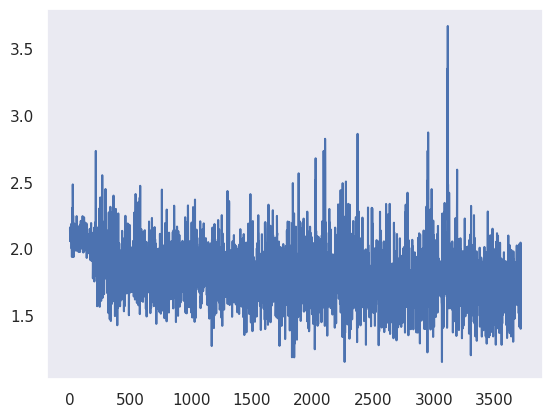

In [27]:
plt.plot(train_losses)

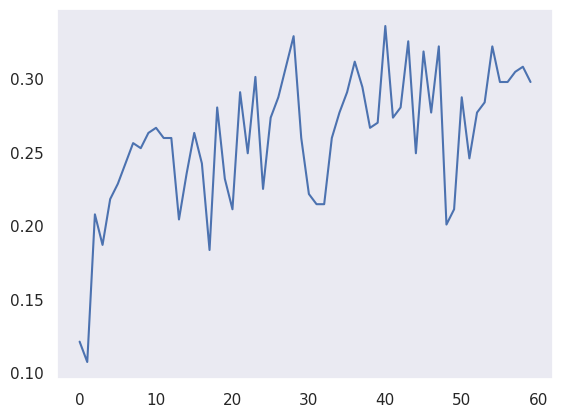

In [28]:
plt.plot(test_accuracy)

In [29]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 86/289 (0.2976)
F1: 0.2986111044883728
UAP: 0.23552632331848145
WAP: 0.2986111044883728
UAR: 0.28491151332855225
WAR: 0.2986111044883728
tensor([[ 0,  4,  0,  1,  0,  0, 12,  0],
        [ 0, 31,  3,  1,  0,  0,  6,  0],
        [ 0,  0, 17,  0, 13,  2, 13,  2],
        [ 0, 15, 12,  0,  1,  1, 12,  5],
        [ 0,  0,  8,  0, 16,  0,  5,  2],
        [ 0,  2, 12,  1,  9,  1,  8,  5],
        [ 0,  5, 12,  0,  0,  0, 10,  8],
        [ 0,  0, 12,  0,  1,  0,  9, 11]], device='cuda:0')


In [30]:
model_path = '../ravdess_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [31]:
from IConNet.visualizer import visualize_model

In [32]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [33]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 4.4566e-17],
        [-4.9031e-17],
        [-1.2673e-17],
        [ 2.0687e-17],
        [-1.5834e-17],
        [ 9.6267e-19],
        [ 3.4253e-18],
        [ 5.7141e-18],
        [-1.6504e-19],
        [-7.8680e-18],
        [-1.8146e-18],
        [-1.2394e-18],
        [-3.2290e-17],
        [-9.3106e-18],
        [-2.6795e-20],
        [-5.0746e-18],
        [-4.2224e-18],
        [-3.1784e-19],
        [ 1.0509e-19],
        [ 6.2901e-19],
        [ 4.3442e-20],
        [-1.0461e-19],
        [-4.5857e-20],
        [-1.8772e-18],
        [ 3.4843e-18],
        [-4.7064e-20],
        [ 1.6165e-20],
        [ 2.2595e-20],
        [ 2.4139e-20],
        [ 1.3511e-20],
        [-3.2204e-20],
        [ 0.0000e+00],
        [ 1.9828e-18],
        [ 1.4758e-20],
        [ 5.3617e-16],
        [-1.1169e-17],
        [ 5.5659e-19],
        [ 7.4929e-18],
        [ 1.4192e-18],
        [ 6.5028e-19],
        [-9.0270e-19],
        [-5.6896e-19],
        [-7

[None, None, None]

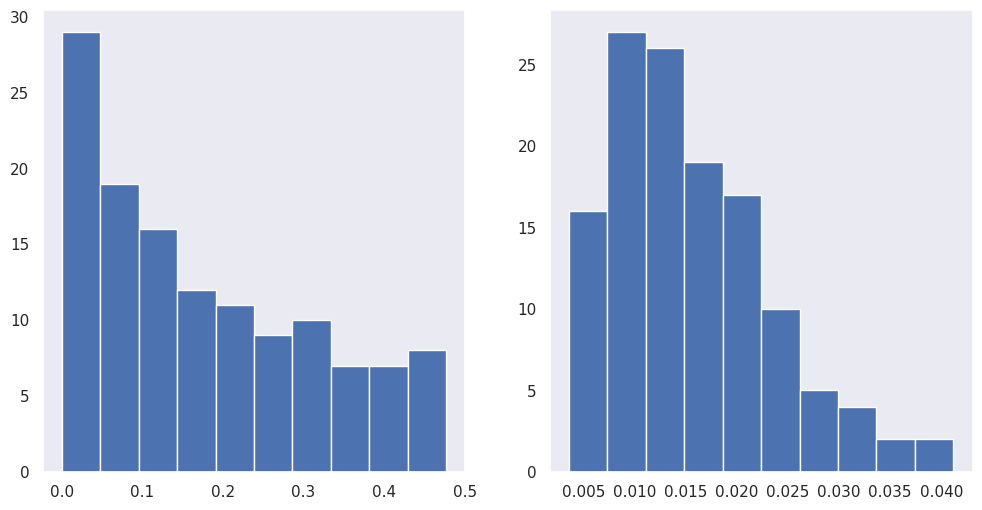

In [34]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

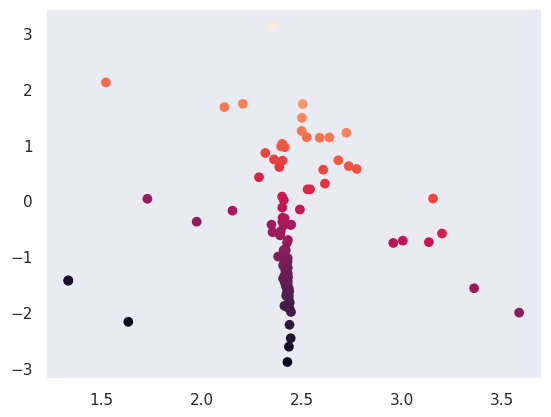

In [35]:
filtviz.visualize_window_params()

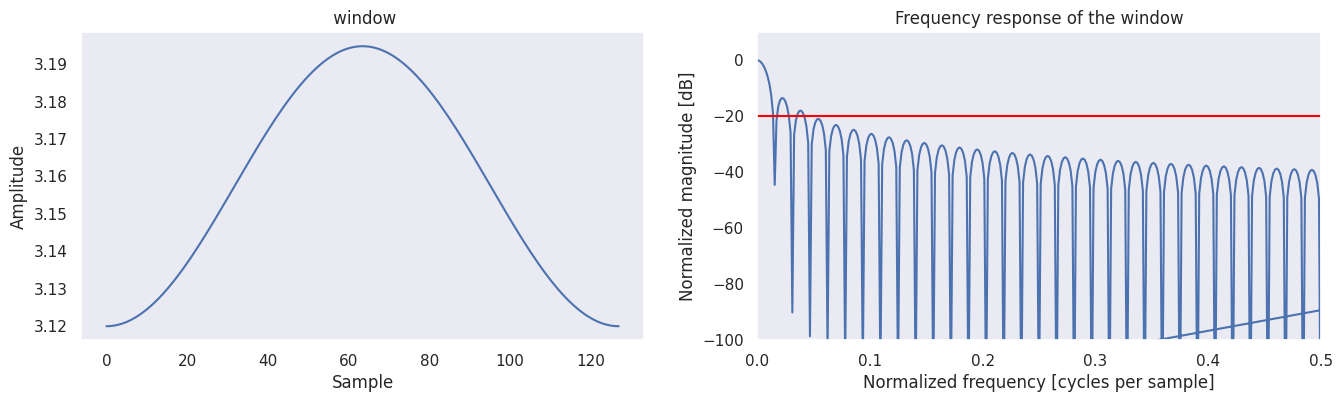

In [39]:
filtviz.visualize_one_window(n_out=0, n_inp=0)

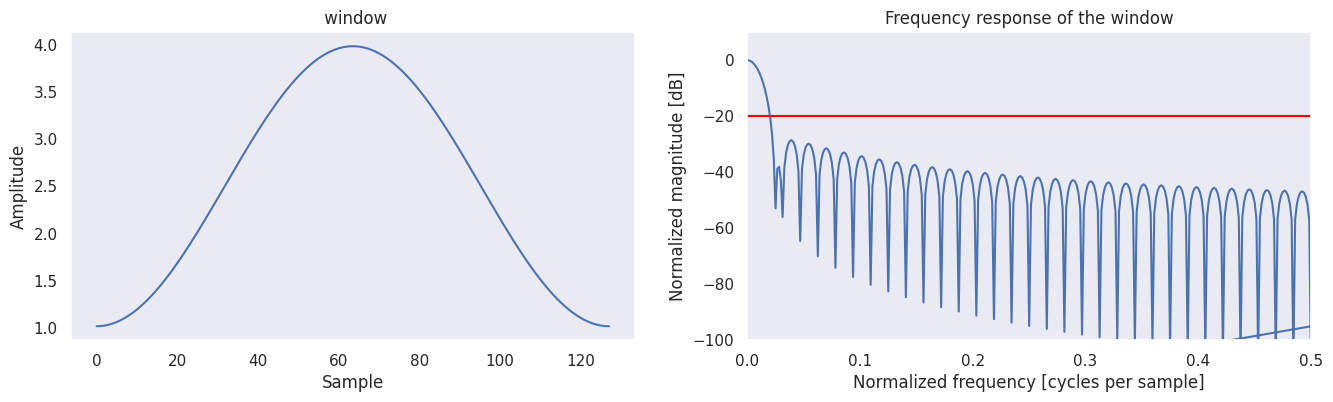

In [36]:
filtviz.visualize_one_window(n_out=10, n_inp=0)

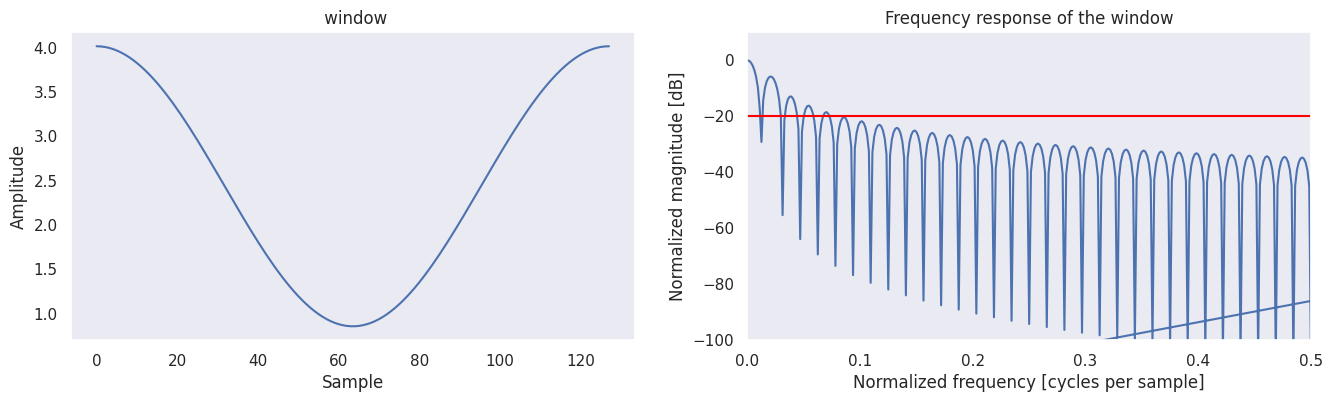

In [45]:
filtviz.visualize_one_window(n_out=52, n_inp=0)

Time domain: Filters' shapes vary by frequency bins


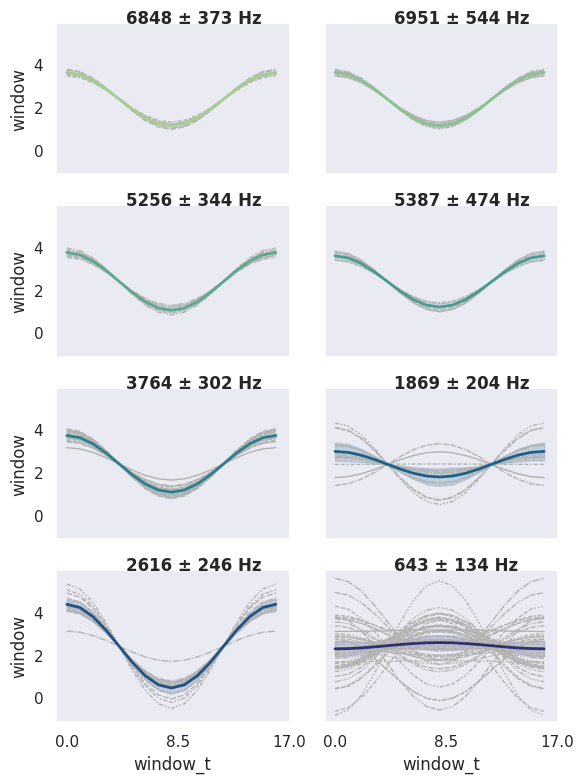

In [46]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


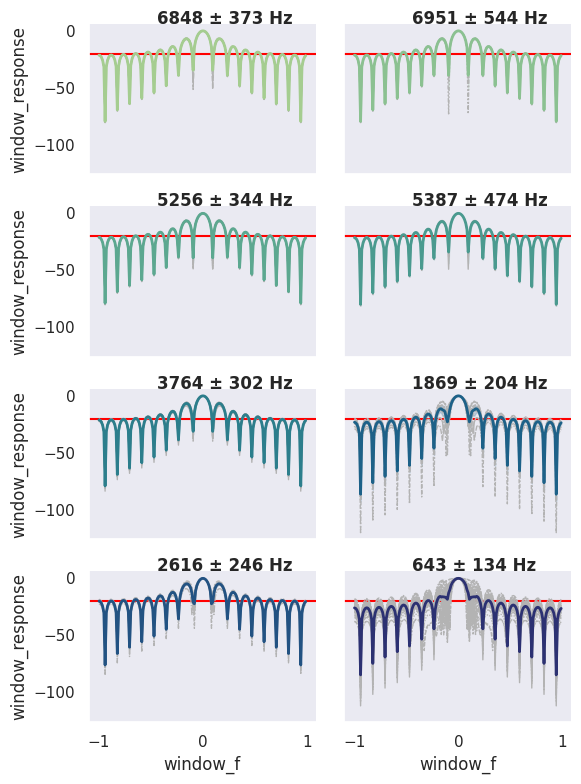

In [47]:
filtviz.visualize_filters(filter_domain='freq')

In [48]:
del model
gc.collect()

32620